In [29]:
#Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

In [30]:
#Read the daily city-wise data
df= pd.read_csv("city_day.csv",parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

In [31]:
#Keeping only the columns needed
df=df[['City','Date','AQI']]

In [32]:
#Filtering the dataframe to keep the data for the city of Delhi only
delhi = df[df['City'] == 'Delhi']
delhi.drop(['City'],axis=1,inplace = True)
delhi.set_index('Date', inplace = True)

In [33]:
delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


In [34]:
#Fill NULL DATA
delhi['AQI'].fillna(method = 'bfill',inplace = True)

In [35]:
#Taking monthly average
delhi=delhi.astype('float64')
delhi=delhi.resample(rule='MS').mean()

In [41]:
delhi

,AQI
Date,
2015-01-01,342.290323
2015-02-01,327.928571
2015-03-01,256.064516
2015-04-01,305.266667
2015-05-01,348.580645
...,...
2020-03-01,135.838710
2020-04-01,113.000000
2020-05-01,148.645161


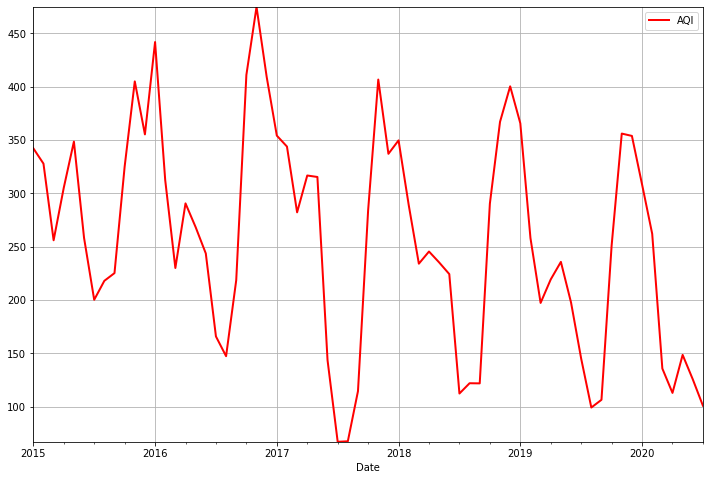

In [36]:
ax=delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

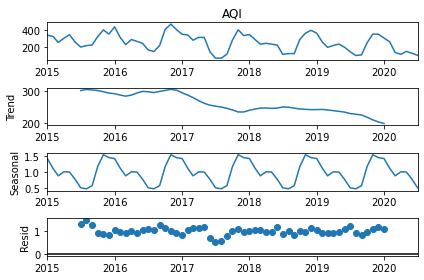

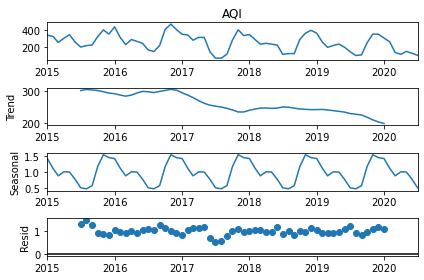

In [38]:
delhi_AQI=delhi['AQI']
result=seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot()

In [39]:
#Importing the SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [40]:
len(delhi_AQI)

67

In [42]:
#Splitting the training and testing dataset
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

In [43]:
#Defining our model and fitting on the training data
model=SARIMAX(train,order=(0,1,3),seasonal_order=(0,1,1,12))
results=model.fit()
results.summary()

C:\Users\deepa\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -185.444
Date:                              Fri, 04 Mar 2022   AIC                            380.888
Time:                                      22:55:13   BIC                            388.665
Sample:                                  01-01-2015   HQIC                           383.573
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5594      9.903     -0.056      0.955     -19.969      18.850
ma.L2         -0.0811      4.388     -0.018      0.985      -8.681       8.519
ma.L3         -0.3564      3.689     -0.097      0.923      -7.586       6.873
ma.S.L12      -0.9983    156.339     -0.006      0.995    -307.417     305.421
sigma2      1324.6725   2.06e+05      0.006      0.995   -4.03e+05    4.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.43   Prob(JB):                         0.89
Heteroskedasticity (H):               0.54   Skew:                             0.20
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
#Predicting on our train and test dataset
train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')

<AxesSubplot:xlabel='Date'>

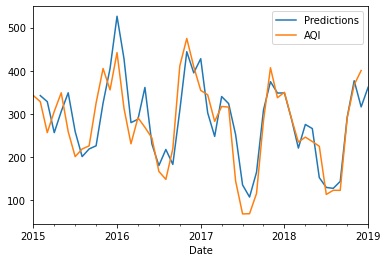

In [45]:
#Plotting the train predictions to see the fit of the model
train_predictions.plot(legend=True)
train.plot(legend=True)

In [46]:
#Calculating the RMSE value on the training dataset 
RMSE=np.sqrt(mean_squared_error(train_predictions,train))
print('RMSE = ',RMSE)
print('Mean AQI',train.mean())

RMSE =  66.3928352796022
Mean AQI 275.1711046334552


<AxesSubplot:xlabel='Date'>

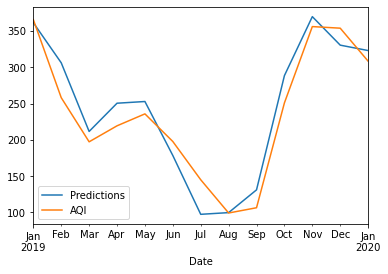

In [47]:
#Plotting the test predictions to see how well our model generalized
test_predictions.plot(legend=True)
test.plot(legend=True)

In [48]:
#Calculating the RMSE value on the testing dataset 
RMSE=np.sqrt(mean_squared_error(test_predictions,test))
print('RMSE = ',RMSE)
print('Mean AQI',test.mean())

RMSE =  26.882105805698423
Mean AQI 238.05046082949306


<AxesSubplot:xlabel='Date'>

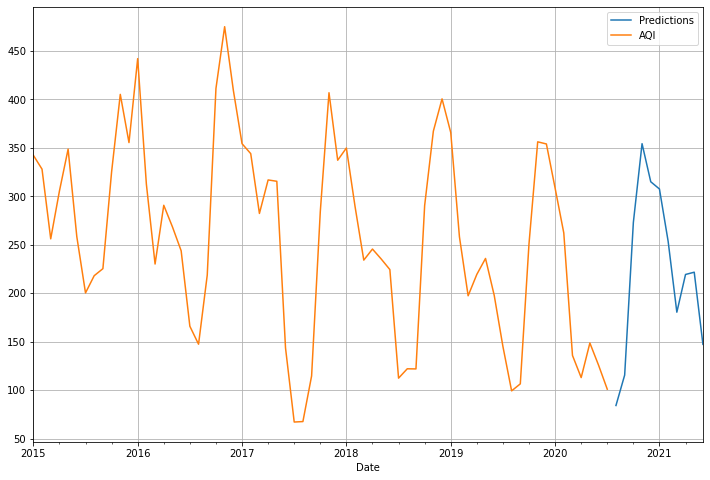

In [53]:
#Obtaining predicted values:
future_predictions = results.predict(start=67, end=77, typ='levels').rename('Predictions')

#Plotting predicted values against the true values:
future_predictions.plot(legend=True)
delhi_AQI.plot(legend=True,figsize=(12,8),grid=True)

In [50]:
def grid_search(p,d,q,P,D,Q,m,train,test):
    
    column_names = ['p','d','q','P','D','Q','m','RMSE_train','RMSE_test']
    df = pd.DataFrame(columns = column_names)

    for p1 in p:
        for p2 in d:
            for p3 in q:
                for p4 in P:
                    for p5 in D:
                        for p6 in Q:
                            for p7 in m:
                                
                                
                                model=SARIMAX(train,order=(p1,p2,p3),seasonal_order=(p4,p5,p6,p7))
                                try:
                                    results=model.fit()
                                except:
                                    print("Passing on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                    pass
                                print("Fitting on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                #results.summary()
                                #Predicting on our train and test dataset
                                train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
                                test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')
                                
                                #Calculating the RMSE value on the training dataset 
                                RMSE_train = np.sqrt(mean_squared_error(train_predictions,train))
                                #Calculating the RMSE value on the testing dataset 
                                RMSE_test=np.sqrt(mean_squared_error(test_predictions,test))
                                
                                #Fill our dataframe
                                df = df.append({'p':p1, 'd':p2,'q':p3,
                                                'P':p4,'D':p5,'Q':p6,'m':p7,
                                                'RMSE_train' : RMSE_train, 'RMSE_test' : RMSE_test},
                                               ignore_index = True)
                                print(df.tail(1))
                                
                                
                                
    return df
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

p = [1,2,3,0]
d = [1,2,3,0]
q = [1,2,3,0]
P = [1,2,3,0]
D = [1,2,3,0]
Q = [1,2,3,0]
m = [12]

table = grid_search(p,d,q,P,D,Q,m,train,test)